### Import libraries

In [11]:
#import libraries
import xarray as xr 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 


### Investigate nc files

In [48]:
data1=xr.open_dataset('/vol/sandeep_storage/Files2/catastrophe/t2m_24.nc')
data1


<xarray.Dataset> Size: 54MB
Dimensions:     (valid_time: 8784, latitude: 25, longitude: 61)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 70kB 2024-01-01 ... 2024-12-31T23...
  * latitude    (latitude) float64 200B 23.0 22.75 22.5 ... 17.5 17.25 17.0
  * longitude   (longitude) float64 488B 75.0 75.25 75.5 ... 89.5 89.75 90.0
    expver      (valid_time) <U4 141kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 54MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-14T21:12 GRIB to CDM+CF via cfgrib-0.9.1...

In [66]:
data2=xr.open_dataset('/vol/sandeep_storage/Files2/catastrophe/tp_24.nc')
data2


<xarray.Dataset> Size: 54MB
Dimensions:     (valid_time: 8784, latitude: 25, longitude: 61)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 70kB 2024-01-01 ... 2024-12-31T23...
  * latitude    (latitude) float64 200B 23.0 22.75 22.5 ... 17.5 17.25 17.0
  * longitude   (longitude) float64 488B 75.0 75.25 75.5 ... 89.5 89.75 90.0
    expver      (valid_time) <U4 141kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 54MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-15T03:33 GRIB to CDM+CF via cfgrib-0.9.1...

-----

### Calculate hourly t2m(2m temperature)-->daily t2m and converting K-->C + store 

In [1]:
import xarray as xr
import pandas as pd

# ---------------------------
# Input file paths
# ---------------------------
files = [
    "/vol/sandeep_storage/Files2/catastrophe/t2m_20_21.nc",
    "/vol/sandeep_storage/Files2/catastrophe/t2m_22_23.nc",
    "/vol/sandeep_storage/Files2/catastrophe/t2m_24.nc"
]

# ---------------------------
# Load & concatenate
# ---------------------------
ds = xr.open_mfdataset(files, combine="by_coords")

# ---------------------------
# Convert time to daily mean
# ---------------------------
# ERA5 is hourly → daily mean
ds_daily = ds.resample(valid_time="1D").mean()

# ---------------------------
# Convert Kelvin → Celsius
# ---------------------------
ds_daily["t2m"] = ds_daily["t2m"] - 273.15

# ---------------------------
# Convert to long-table pandas DF
# Keeps lat, lon, date exactly
# ---------------------------
df = ds_daily["t2m"].to_dataframe().reset_index()

# Ensure proper dtypes
df["valid_time"] = pd.to_datetime(df["valid_time"])

# ---------------------------
# Save as a single Parquet file
# ---------------------------
output_path = "/vol/sandeep_storage/Files2/catastrophe/t2m_daily_2020_2024.parquet"
df.to_parquet(output_path, index=False)

print("Saved daily t2m parquet file to:", output_path)


Saved daily t2m parquet file to: /vol/sandeep_storage/Files2/catastrophe/t2m_daily_2020_2024.parquet


In [2]:
t2m_=pd.read_parquet('/vol/sandeep_storage/Files2/catastrophe/t2m_daily_2020_2024.parquet')
t2m_


,valid_time,latitude,longitude,number,t2m
0,2020-01-01,23.0,75.00,0,17.106018
1,2020-01-01,23.0,75.25,0,16.485748
2,2020-01-01,23.0,75.50,0,16.159821
3,2020-01-01,23.0,75.75,0,16.009094
4,2020-01-01,23.0,76.00,0,15.876953
...,...,...,...,...,...
2786170,2024-12-31,17.0,89.00,0,25.253540
2786171,2024-12-31,17.0,89.25,0,25.250793
2786172,2024-12-31,17.0,89.50,0,25.241089
2786173,2024-12-31,17.0,89.75,0,25.249481


In [3]:
# drop number column
t2m_=t2m_.drop(columns=['number'])
t2m_.to_parquet('/vol/sandeep_storage/Files2/catastrophe/t2m_daily_2020_2024_clean.parquet')


In [4]:
t2m=pd.read_parquet('/vol/sandeep_storage/Files2/catastrophe/t2m_daily_2020_2024_clean.parquet')
t2m


,valid_time,latitude,longitude,t2m
0,2020-01-01,23.0,75.00,17.106018
1,2020-01-01,23.0,75.25,16.485748
2,2020-01-01,23.0,75.50,16.159821
3,2020-01-01,23.0,75.75,16.009094
4,2020-01-01,23.0,76.00,15.876953
...,...,...,...,...
2786170,2024-12-31,17.0,89.00,25.253540
2786171,2024-12-31,17.0,89.25,25.250793
2786172,2024-12-31,17.0,89.50,25.241089
2786173,2024-12-31,17.0,89.75,25.249481


-----

### Calculate daily tp (Total precipitation(m)) + store

In [67]:
import xarray as xr
import pandas as pd

# ---------------------------
# Input file paths
# ---------------------------
files = [
    "/vol/sandeep_storage/Files2/catastrophe/tp_20_21.nc",
    "/vol/sandeep_storage/Files2/catastrophe/tp_22_23.nc",
    "/vol/sandeep_storage/Files2/catastrophe/tp_24.nc"
]

# ---------------------------
# Load & concatenate
# ---------------------------
ds = xr.open_mfdataset(files, combine="by_coords")

# ---------------------------
# Convert time to daily mean
# ---------------------------
# ERA5 is hourly → daily mean
ds_daily = ds.resample(valid_time="1D").mean()


# ---------------------------
# Convert to long-table pandas DF
# Keeps lat, lon, date exactly
# ---------------------------
df = ds_daily["tp"].to_dataframe().reset_index()

# Ensure proper dtypes
df["valid_time"] = pd.to_datetime(df["valid_time"])

# ---------------------------
# Save as a single Parquet file
# ---------------------------
output_path = "/vol/sandeep_storage/Files2/catastrophe/tp_daily_2020_2024.parquet"
df.to_parquet(output_path, index=False)

print("Saved daily tp parquet file to:", output_path)


Saved daily tp parquet file to: /vol/sandeep_storage/Files2/catastrophe/tp_daily_2020_2024.parquet


In [71]:
tp_=pd.read_parquet('/vol/sandeep_storage/Files2/catastrophe/tp_daily_2020_2024.parquet')
tp_


,valid_time,latitude,longitude,number,tp
0,2020-01-01,23.0,75.00,0,1.392762e-05
1,2020-01-01,23.0,75.25,0,2.568960e-05
2,2020-01-01,23.0,75.50,0,3.759066e-05
3,2020-01-01,23.0,75.75,0,4.198154e-05
4,2020-01-01,23.0,76.00,0,4.726648e-05
...,...,...,...,...,...
2786170,2024-12-31,17.0,89.00,0,3.973643e-08
2786171,2024-12-31,17.0,89.25,0,0.000000e+00
2786172,2024-12-31,17.0,89.50,0,0.000000e+00
2786173,2024-12-31,17.0,89.75,0,0.000000e+00


In [72]:
# drop number column
tp_=tp_.drop(columns=['number'])
tp_.to_parquet('/vol/sandeep_storage/Files2/catastrophe/tp_daily_2020_2024_clean.parquet')


In [5]:
tp=pd.read_parquet('/vol/sandeep_storage/Files2/catastrophe/tp_daily_2020_2024_clean.parquet')
tp


,valid_time,latitude,longitude,tp
0,2020-01-01,23.0,75.00,1.392762e-05
1,2020-01-01,23.0,75.25,2.568960e-05
2,2020-01-01,23.0,75.50,3.759066e-05
3,2020-01-01,23.0,75.75,4.198154e-05
4,2020-01-01,23.0,76.00,4.726648e-05
...,...,...,...,...
2786170,2024-12-31,17.0,89.00,3.973643e-08
2786171,2024-12-31,17.0,89.25,0.000000e+00
2786172,2024-12-31,17.0,89.50,0.000000e+00
2786173,2024-12-31,17.0,89.75,0.000000e+00


### Merge t2m + tp into a single spatiotemporal dataset 

In [7]:

# Load both datasets
t2m = pd.read_parquet('/vol/sandeep_storage/Files2/catastrophe/t2m_daily_2020_2024_clean.parquet')
tp = pd.read_parquet('/vol/sandeep_storage/Files2/catastrophe/tp_daily_2020_2024_clean.parquet')

# Merge on (time, lat, lon)
df = t2m.merge(tp, on=["valid_time", "latitude", "longitude"], how="inner")

# Sort for convenience
df = df.sort_values(["valid_time", "latitude", "longitude"]).reset_index(drop=True)

# Save merged dataset
df.to_parquet('/vol/sandeep_storage/Files2/catastrophe/era5_temp_precip_daily_2020_2024.parquet')

df.shape


(2786175, 5)

In [9]:
data=pd.read_parquet('/vol/sandeep_storage/Files2/catastrophe/era5_temp_precip_daily_2020_2024.parquet')
data


,valid_time,latitude,longitude,t2m,tp
0,2020-01-01,17.0,75.00,24.108643,0.000027
1,2020-01-01,17.0,75.25,24.710449,0.000024
2,2020-01-01,17.0,75.50,25.029602,0.000025
3,2020-01-01,17.0,75.75,25.409241,0.000033
4,2020-01-01,17.0,76.00,25.478027,0.000016
...,...,...,...,...,...
2786170,2024-12-31,23.0,89.00,18.370575,0.000000
2786171,2024-12-31,23.0,89.25,18.370331,0.000000
2786172,2024-12-31,23.0,89.50,18.427368,0.000000
2786173,2024-12-31,23.0,89.75,18.472717,0.000000


----

### XGBoost

### Feature engineering 

In [9]:
import pandas as pd
import numpy as np

# --------------------------
# 1. Load data
# --------------------------
df = pd.read_parquet('/vol/sandeep_storage/Files2/catastrophe/era5_temp_precip_daily_2020_2024.parquet')

# Ensure datetime
df["valid_time"] = pd.to_datetime(df["valid_time"])

# --------------------------
# 2. Geographic Encodings (STATIC FEATURES)
# --------------------------
df["lat_sin"] = np.sin(np.deg2rad(df["latitude"]))
df["lat_cos"] = np.cos(np.deg2rad(df["latitude"]))
df["lon_sin"] = np.sin(np.deg2rad(df["longitude"]))
df["lon_cos"] = np.cos(np.deg2rad(df["longitude"]))

# --------------------------
# 3. Sort for lag/rolling
# --------------------------
df = df.sort_values(["latitude", "longitude", "valid_time"]).reset_index(drop=True)

# Group by gridpoint
g = df.groupby(["latitude", "longitude"])

# --------------------------
# 4. Lag features (1,3,7 days)
# --------------------------
for lag in [1, 3, 7]:
    df[f"t2m_lag{lag}"] = g["t2m"].shift(lag)
    df[f"tp_lag{lag}"]  = g["tp"].shift(lag)

# --------------------------
# 5. Rolling mean features
# --------------------------
for win in [7, 14]:
    df[f"t2m_roll{win}"] = (
        g["t2m"].rolling(win).mean().reset_index(level=[0,1], drop=True)
    )
    df[f"tp_roll{win}"] = (
        g["tp"].rolling(win).mean().reset_index(level=[0,1], drop=True)
    )

# --------------------------
# 6. Seasonality (Day-of-year)
# --------------------------
df["doy"] = df["valid_time"].dt.dayofyear
df["doy_sin"] = np.sin(2 * np.pi * df["doy"] / 365)
df["doy_cos"] = np.cos(2 * np.pi * df["doy"] / 365)

# --------------------------
# 7. Targets (next-day prediction)
# --------------------------
df["t2m_target"] = g["t2m"].shift(-1)
df["tp_target"]  = g["tp"].shift(-1)

# --------------------------
# 8. Drop incomplete rows
# --------------------------
df_xgb = df.dropna().reset_index(drop=True)

# --------------------------
# 9. Save final engineered dataset
# --------------------------
df_xgb.to_parquet('/vol/sandeep_storage/Files2/catastrophe/xgb_features_2020_2024_new.parquet')

print("DONE — Saved engineered features with lat/lon sin-cos encoding.")


DONE — Saved engineered features with lat/lon sin-cos encoding.


In [10]:
df_xgb.shape


(2764825, 24)

In [11]:
df_xgb_=pd.read_parquet('/vol/sandeep_storage/Files2/catastrophe/xgb_features_2020_2024_new.parquet')
df_xgb_


,valid_time,latitude,longitude,t2m,tp,lat_sin,lat_cos,lon_sin,lon_cos,t2m_lag1,...,tp_lag7,t2m_roll7,tp_roll7,t2m_roll14,tp_roll14,doy,doy_sin,doy_cos,t2m_target,tp_target
0,2020-01-14,17.0,75.0,24.131531,0.000000e+00,0.292372,0.956305,0.965926,2.588190e-01,23.503662,...,0.000004,23.507935,6.062644e-06,23.431902,0.000006,14,2.386728e-01,0.971100,23.715424,0.000000e+00
1,2020-01-15,17.0,75.0,23.715424,0.000000e+00,0.292372,0.956305,0.965926,2.588190e-01,24.131531,...,0.000017,23.357378,3.686973e-06,23.403815,0.000005,15,2.553533e-01,0.966848,22.176941,3.973643e-08
2,2020-01-16,17.0,75.0,22.176941,3.973643e-08,0.292372,0.956305,0.965926,2.588190e-01,23.715424,...,0.000003,23.149632,3.218651e-06,23.274148,0.000004,16,2.719582e-01,0.962309,21.861725,0.000000e+00
3,2020-01-17,17.0,75.0,21.861725,0.000000e+00,0.292372,0.956305,0.965926,2.588190e-01,22.176941,...,0.000016,23.034777,9.990874e-07,23.217019,0.000004,17,2.884824e-01,0.957485,24.054810,0.000000e+00
4,2020-01-18,17.0,75.0,24.054810,0.000000e+00,0.292372,0.956305,0.965926,2.588190e-01,21.861725,...,0.000007,23.193952,5.676633e-09,23.368114,0.000004,18,3.049212e-01,0.952378,25.206024,7.708867e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764820,2024-12-26,23.0,90.0,20.540131,0.000000e+00,0.390731,0.920505,1.000000,6.123234e-17,20.142883,...,0.000000,19.650133,1.739604e-05,19.130064,0.000009,361,-6.880243e-02,0.997630,19.357819,0.000000e+00
2764821,2024-12-27,23.0,90.0,19.357819,0.000000e+00,0.390731,0.920505,1.000000,6.123234e-17,20.540131,...,0.000002,19.550214,1.711221e-05,19.264605,0.000009,362,-5.161967e-02,0.998667,19.227875,0.000000e+00
2764822,2024-12-28,23.0,90.0,19.227875,0.000000e+00,0.390731,0.920505,1.000000,6.123234e-17,19.357819,...,0.000024,19.662960,1.372894e-05,19.395094,0.000009,363,-3.442161e-02,0.999407,19.766022,0.000000e+00
2764823,2024-12-29,23.0,90.0,19.766022,0.000000e+00,0.390731,0.920505,1.000000,6.123234e-17,19.227875,...,0.000000,19.734262,1.372894e-05,19.561988,0.000009,364,-1.721336e-02,0.999852,20.455933,0.000000e+00


### Model training

In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# --------------------------
# 1. Load engineered dataset
# --------------------------
df = pd.read_parquet('/vol/sandeep_storage/Files2/catastrophe/xgb_features_2020_2024_new.parquet')
df["valid_time"] = pd.to_datetime(df["valid_time"])

# --------------------------
# 2. Temporal Train/Val/Test Split
# --------------------------
train = df[df["valid_time"].dt.year.isin([2020, 2021, 2022])]
val   = df[df["valid_time"].dt.year == 2023]
test  = df[df["valid_time"].dt.year == 2024]

X_train = train.drop(columns=["t2m_target","tp_target"])
y_train_t2m = train["t2m_target"]
y_train_tp  = train["tp_target"]

X_val = val.drop(columns=["t2m_target","tp_target"])
y_val_t2m = val["t2m_target"]
y_val_tp  = val["tp_target"]

X_test = test.drop(columns=["t2m_target","tp_target"])
y_test_t2m = test["t2m_target"]
y_test_tp  = test["tp_target"]

# Only choose model features
feature_cols = [
    "t2m","tp",
    "t2m_lag1","t2m_lag3","t2m_lag7",
    "tp_lag1","tp_lag3","tp_lag7",
    "t2m_roll7","t2m_roll14",
    "tp_roll7","tp_roll14",
    "doy_sin","doy_cos",
    "latitude","longitude",
    "lat_sin","lat_cos",
    "lon_sin","lon_cos"
]

X_train = X_train[feature_cols]
X_val   = X_val[feature_cols]
X_test  = X_test[feature_cols]

# Combine train + val for final training after tuning
X_train_full = pd.concat([X_train, X_val])
y_train_full_t2m = pd.concat([y_train_t2m, y_val_t2m])
y_train_full_tp  = pd.concat([y_train_tp, y_val_tp])

# --------------------------
# 3. TimeSeries Cross-validation
# --------------------------
tscv = TimeSeriesSplit(n_splits=3)

# --------------------------
# 4. Hyperparameter Search Space
# --------------------------
param_dist = {
    "n_estimators": [400, 600, 800],
    "learning_rate": [0.005, 0.01, 0.02, 0.03],
    "max_depth": [4, 6, 8, 10],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [1, 1.5, 2],
    "min_child_weight": [1, 3, 5],
}

base_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    eval_metric="rmse"
)

# --------------------------
# 5. Randomized Search (Temperature model)
# --------------------------
search_t2m = RandomizedSearchCV(
    base_model,
    param_distributions=param_dist,
    n_iter=25,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    verbose=2,
    n_jobs=-1
)

search_t2m.fit(X_train, y_train_t2m)
best_t2m_params = search_t2m.best_params_
print("\nBest params (t2m):", best_t2m_params)

# --------------------------
# 6. Randomized Search (Precip model)
# --------------------------
search_tp = RandomizedSearchCV(
    base_model,
    param_distributions=param_dist,
    n_iter=25,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    verbose=2,
    n_jobs=-1
)

search_tp.fit(X_train, y_train_tp)
best_tp_params = search_tp.best_params_
print("\nBest params (tp):", best_tp_params)

# --------------------------
# 7. Train FINAL MODELS on Train+Val
# --------------------------
model_t2m = xgb.XGBRegressor(**best_t2m_params, objective="reg:squarederror")
model_t2m.fit(X_train_full, y_train_full_t2m)

model_tp = xgb.XGBRegressor(**best_tp_params, objective="reg:squarederror")
model_tp.fit(X_train_full, y_train_full_tp)

# --------------------------
# 8. Evaluate on Test (2024)
# --------------------------
pred_t2m = model_t2m.predict(X_test)
pred_tp  = model_tp.predict(X_test)

rmse_t2m = np.sqrt(mean_squared_error(y_test_t2m, pred_t2m))
rmse_tp  = np.sqrt(mean_squared_error(y_test_tp, pred_tp))

print("\n===== FINAL TEST METRICS =====")
print("T2M Test RMSE:", rmse_t2m)
print("TP  Test RMSE:", rmse_tp)



Fitting 3 folds for each of 25 candidates, totalling 75 fits


/home/sandeep/.conda/envs/sahu/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/sandeep/.conda/envs/sahu/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of 

[CV] END colsample_bytree=0.9, learning_rate=0.005, max_depth=4, min_child_weight=1, n_estimators=400, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=  39.1s
[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=600, reg_alpha=0, reg_lambda=1.5, subsample=0.8; total time=  50.0s
[CV] END colsample_bytree=0.9, learning_rate=0.005, max_depth=4, min_child_weight=1, n_estimators=400, reg_alpha=0.1, reg_lambda=2, subsample=0.7; total time= 1.1min
[CV] END colsample_bytree=0.8, learning_rate=0.02, max_depth=4, min_child_weight=3, n_estimators=800, reg_alpha=0.5, reg_lambda=2, subsample=0.8; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.005, max_depth=6, min_child_weight=5, n_estimators=400, reg_alpha=0, reg_lambda=1, subsample=0.7; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=8, min_child_weight=1, n_estimators=400, reg_alpha=0.1, reg_lambda=1.5, subsample=0.8; total time= 1.3min
[CV] EN

### Cross validation results

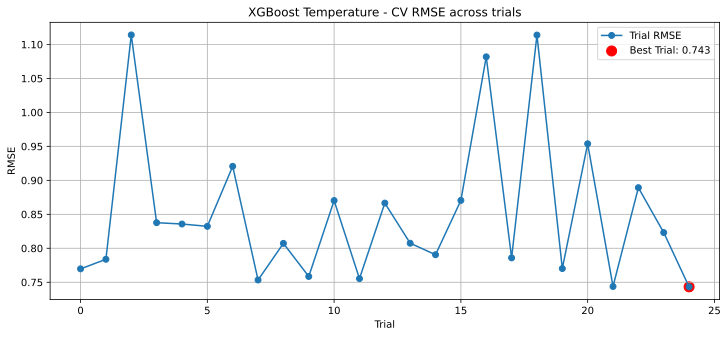

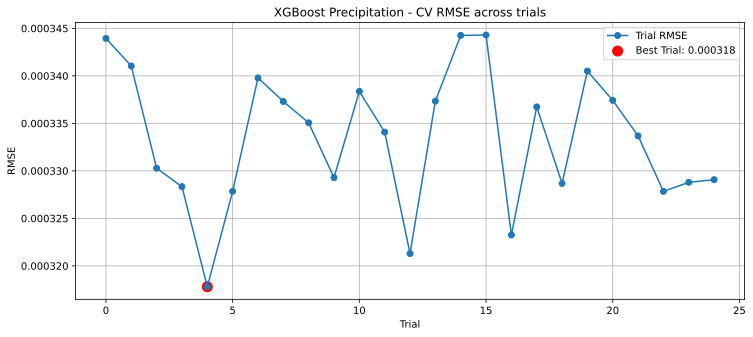

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# ---------- Temperature ----------
t2m_rmse = -search_t2m.cv_results_['mean_test_score']
best_idx_t2m = np.argmin(t2m_rmse)
best_rmse_t2m = t2m_rmse[best_idx_t2m]

plt.figure(figsize=(12, 5))
plt.plot(t2m_rmse, marker='o', linestyle='-', label='Trial RMSE')
plt.scatter(best_idx_t2m, best_rmse_t2m, color='red', s=100, label=f'Best Trial: {best_rmse_t2m:.3f}')
plt.title("XGBoost Temperature - CV RMSE across trials")
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

# ---------- Precipitation ----------
tp_rmse = -search_tp.cv_results_['mean_test_score']
best_idx_tp = np.argmin(tp_rmse)
best_rmse_tp = tp_rmse[best_idx_tp]

plt.figure(figsize=(12, 5))
plt.plot(tp_rmse, marker='o', linestyle='-', label='Trial RMSE')
plt.scatter(best_idx_tp, best_rmse_tp, color='red', s=100, label=f'Best Trial: {best_rmse_tp:.6f}')
plt.title("XGBoost Precipitation - CV RMSE across trials")
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()


### Feature importance 

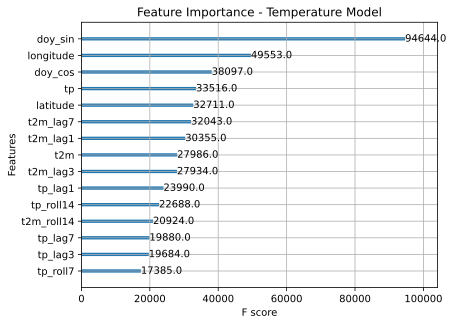

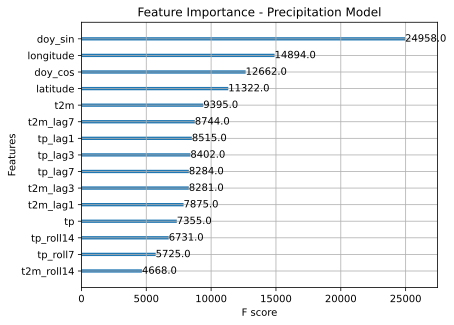

In [35]:

# --------------------------
# Feature Importance
# --------------------------
xgb.plot_importance(model_t2m, max_num_features=15)
plt.title("Feature Importance - Temperature Model")
plt.show()

xgb.plot_importance(model_tp, max_num_features=15)
plt.title("Feature Importance - Precipitation Model")
plt.show()


### Save XGB results

In [18]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# --------------------------
# Create directories to save results
# --------------------------
save_dir = "/vol/sandeep_storage/Files2/catastrophe/xgb_outputs"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(os.path.join(save_dir, "plots"), exist_ok=True)

# --------------------------
# 1. Save trained models
# --------------------------
with open(os.path.join(save_dir, "model_t2m.pkl"), "wb") as f:
    pickle.dump(model_t2m, f)

with open(os.path.join(save_dir, "model_tp.pkl"), "wb") as f:
    pickle.dump(model_tp, f)

# --------------------------
# 2. Save best hyperparameters
# --------------------------
params = {
    "t2m_best_params": best_t2m_params,
    "tp_best_params": best_tp_params
}

with open(os.path.join(save_dir, "best_params.pkl"), "wb") as f:
    pickle.dump(params, f)

# --------------------------
# 3. Save test predictions alongside true values & coordinates
# --------------------------
X_test_copy = X_test.copy()
X_test_copy['t2m_true'] = y_test_t2m.values
X_test_copy['t2m_pred'] = pred_t2m
X_test_copy['tp_true']  = y_test_tp.values
X_test_copy['tp_pred']  = pred_tp

X_test_copy.to_parquet(os.path.join(save_dir, "xgb_test_predictions.parquet"), index=False)

# --------------------------
# 4. Save overall metrics
# --------------------------
metrics = {
    "t2m_test_rmse": np.sqrt(mean_squared_error(y_test_t2m, pred_t2m)),
    "tp_test_rmse": np.sqrt(mean_squared_error(y_test_tp, pred_tp))
}

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(os.path.join(save_dir, "overall_metrics.csv"), index=False)


print(" XGBoost results saved successfully.")


 XGBoost results saved successfully.


----

### Daily RMSE/grid for t2m and tp calculate and save

In [36]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Copy test data with predictions
X_test_copy = X_test.copy()
X_test_copy['t2m_true'] = y_test_t2m.values
X_test_copy['t2m_pred'] = pred_t2m
X_test_copy['tp_true']  = y_test_tp.values
X_test_copy['tp_pred']  = pred_tp
X_test_copy['date'] = test["valid_time"].values

# Function to compute metrics for a day
def compute_daily_metrics(df):
    grouped = df.groupby(['date','latitude','longitude'])
    metrics = grouped.apply(lambda g: pd.Series({
        'rmse': np.sqrt(mean_squared_error(g['t2m_true'], g['t2m_pred'])),
        'rmse_tp': np.sqrt(mean_squared_error(g['tp_true'], g['tp_pred']))
    }))
    return metrics.reset_index()

all_metrics = compute_daily_metrics(X_test_copy)

# Save once as parquet for fast access later
all_metrics.to_parquet("/vol/sandeep_storage/Files2/catastrophe/xgb_outputs/xgb_daily_grid_metrics.parquet", index=False)


In [37]:
grid_data=pd.read_parquet("/vol/sandeep_storage/Files2/catastrophe/xgb_outputs/xgb_daily_grid_metrics.parquet")
grid_data


,date,latitude,longitude,rmse,rmse_tp
0,2024-01-01,17.0,75.00,0.554396,0.000001
1,2024-01-01,17.0,75.25,0.554531,0.000001
2,2024-01-01,17.0,75.50,0.426929,0.000001
3,2024-01-01,17.0,75.75,0.450443,0.000001
4,2024-01-01,17.0,76.00,0.369009,0.000001
...,...,...,...,...,...
556620,2024-12-30,23.0,89.00,1.006731,0.000022
556621,2024-12-30,23.0,89.25,1.312925,0.000014
556622,2024-12-30,23.0,89.50,1.426142,0.000013
556623,2024-12-30,23.0,89.75,1.404318,0.000004


### Plot for a day

### Annotate critical cities

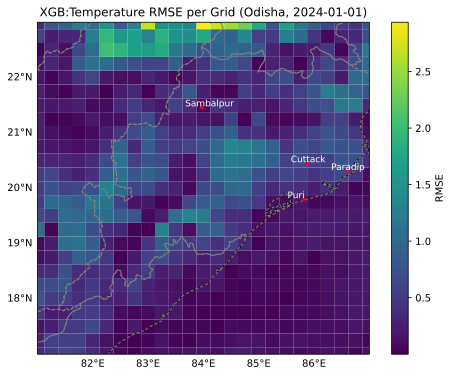

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

file_path = '/vol/sandeep_storage/Files2/catastrophe/xgb_outputs/xgb_daily_grid_metrics.parquet'
all_metrics = pd.read_parquet(file_path)

def plot_odisha_spatial_map_with_cities(df, metric, title, cmap='viridis'):
    # Filter for Odisha approximate extent
    lat_min, lat_max = 17, 23
    lon_min, lon_max = 81, 87
    df = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
            (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]
    
    if df.empty:
        print("No data in the specified extent.")
        return
    
    # Create grid
    lats = np.sort(df['latitude'].unique())
    lons = np.sort(df['longitude'].unique())
    grid = np.full((len(lats), len(lons)), np.nan)
    
    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            val = df[(df['latitude'] == lat) & (df['longitude'] == lon)][metric].values
            if len(val) > 0:
                grid[i, j] = val[0]

    # Plot
    fig = plt.figure(figsize=(10,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    mesh = ax.pcolormesh(lons, lats, grid, shading='auto', cmap=cmap, transform=ccrs.PlateCarree())
    
    # Colorbar
    cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.035, pad=0.04)
    cbar.set_label('RMSE')

    # Map features
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='-', linewidth=1.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linestyle='--', edgecolor='gray')

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, alpha=0)
    gl.top_labels = False
    gl.right_labels = False

    # City locations
    cities = {
        "Cuttack": (20.46, 85.88),      # flood
        "Paradip": (20.32, 86.61),      # cyclone + flood
        "Puri": (19.81, 85.82),         # cyclone + floo     
        "Sambalpur": (21.47, 83.97)     # heatwave
    }
    for city, (lat, lon) in cities.items():
        # Find nearest available gridpoint
        if df.empty:
            continue
        distances = (df['latitude'] - lat)**2 + (df['longitude'] - lon)**2
        if distances.min() < 1.0:  # threshold to ensure it's "nearby"
            nearest_idx = distances.idxmin()
            nearest_val = df.loc[nearest_idx, metric]
            ax.plot(lon, lat, marker='^', color='red', markersize=3, transform=ccrs.PlateCarree())
            ax.text(lon-0.3, lat+0.01, f"{city}", color='white', fontsize=9, transform=ccrs.PlateCarree())
        else:
            print(f"No nearby grid data for {city}")

    ax.set_title(title)
    plt.show()


# Example usage
day_metrics = all_metrics[all_metrics['date'] == '2024-01-01']
plot_odisha_spatial_map_with_cities(day_metrics, 'rmse', "XGB:Temperature RMSE per Grid (Odisha, 2024-01-01)")


### Saving animation for t2m RMSE/grid/day

 GIF saved: odisha_temp_rmse_2024.gif


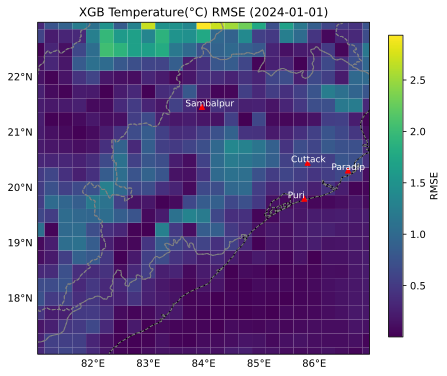

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation, PillowWriter

# --------------------------
# Function to plot Odisha map for animation
# --------------------------
def plot_odisha_map_for_animation(df, metric, title, cmap='viridis', ax=None):
    lat_min, lat_max = 17, 23
    lon_min, lon_max = 81, 87

    df = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
            (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]
    
    if df.empty:
        return

    lats = np.sort(df['latitude'].unique())
    lons = np.sort(df['longitude'].unique())
    grid = np.full((len(lats), len(lons)), np.nan)
    
    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            val = df[(df['latitude'] == lat) & (df['longitude'] == lon)][metric].values
            if len(val) > 0:
                grid[i, j] = val[0]

    if ax is None:
        fig = plt.figure(figsize=(10,6))
        ax = plt.axes(projection=ccrs.PlateCarree())

    ax.clear()
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    mesh = ax.pcolormesh(lons, lats, grid, shading='auto', cmap=cmap, transform=ccrs.PlateCarree())

    # Features
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='-', linewidth=1.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linestyle='--', edgecolor='gray')
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True,linewidth=0.3,alpha=0)
    gl.top_labels = False
    gl.right_labels = False

    # Cities
    cities = {
        "Cuttack": (20.46, 85.88),
        "Paradip": (20.32, 86.61),
        "Puri": (19.81, 85.82),
        "Sambalpur": (21.47, 83.97)
    }
    for city, (lat, lon) in cities.items():
        distances = (df['latitude'] - lat)**2 + (df['longitude'] - lon)**2
        if distances.min() < 1.0:
            nearest_idx = distances.idxmin()
            ax.plot(lon, lat, marker='^', color='red', markersize=5, transform=ccrs.PlateCarree())
            ax.text(lon-0.3, lat+0.01, f"{city}", color='white', fontsize=9, transform=ccrs.PlateCarree())

    ax.set_title(title)
    return mesh, ax

# --------------------------
# Animation setup
# --------------------------
dates = pd.to_datetime(np.sort(all_metrics['date'].unique()))  # convert to pandas Timestamp

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.77, 0.15, 0.02, 0.7])  # separate colorbar axis

def update(day):
    day_str = dates[day].strftime('%Y-%m-%d')
    day_df = all_metrics[all_metrics['date'] == day_str]
    mesh, _ = plot_odisha_map_for_animation(day_df, 'rmse', f"XGB Temperature(°C) RMSE ({day_str})", ax=ax)
    # Add colorbar once
    if day == 0:
        fig.colorbar(mesh, cax=cbar_ax, label='RMSE')

ani = FuncAnimation(fig, update, frames=len(dates), repeat=False)
ani.save('/vol/sandeep_storage/Files2/catastrophe/xgb_outputs/xgbodisha_temp_rmse_2024.gif', writer=PillowWriter(fps=3))

print(" GIF saved: odisha_temp_rmse_2024.gif")


### Same for precipitation

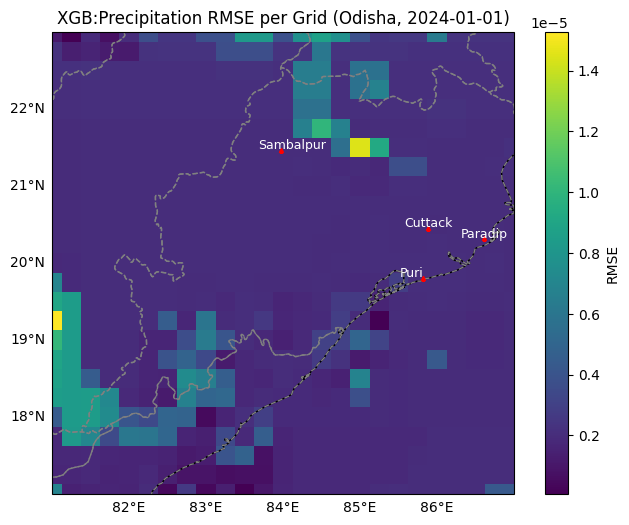

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

file_path = '/vol/sandeep_storage/Files2/catastrophe/xgb_outputs/xgb_daily_grid_metrics.parquet'
all_metrics = pd.read_parquet(file_path)

def plot_odisha_spatial_map_with_cities(df, metric, title, cmap='viridis'):
    # Filter for Odisha approximate extent
    lat_min, lat_max = 17, 23
    lon_min, lon_max = 81, 87
    df = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
            (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]
    
    if df.empty:
        print("No data in the specified extent.")
        return
    
    # Create grid
    lats = np.sort(df['latitude'].unique())
    lons = np.sort(df['longitude'].unique())
    grid = np.full((len(lats), len(lons)), np.nan)
    
    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            val = df[(df['latitude'] == lat) & (df['longitude'] == lon)][metric].values
            if len(val) > 0:
                grid[i, j] = val[0]

    # Plot
    fig = plt.figure(figsize=(10,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    mesh = ax.pcolormesh(lons, lats, grid, shading='auto', cmap=cmap, transform=ccrs.PlateCarree())
    
    # Colorbar
    cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.035, pad=0.04)
    cbar.set_label('RMSE')

    # Map features
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='-', linewidth=1.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linestyle='--', edgecolor='gray')

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, alpha=0)
    gl.top_labels = False
    gl.right_labels = False

    # City locations
    cities = {
        "Cuttack": (20.46, 85.88),      # flood
        "Paradip": (20.32, 86.61),      # cyclone + flood
        "Puri": (19.81, 85.82),         # cyclone + floo     
        "Sambalpur": (21.47, 83.97)     # heatwave
    }
    for city, (lat, lon) in cities.items():
        # Find nearest available gridpoint
        if df.empty:
            continue
        distances = (df['latitude'] - lat)**2 + (df['longitude'] - lon)**2
        if distances.min() < 1.0:  # threshold to ensure it's "nearby"
            nearest_idx = distances.idxmin()
            nearest_val = df.loc[nearest_idx, metric]
            ax.plot(lon, lat, marker='^', color='red', markersize=3, transform=ccrs.PlateCarree())
            ax.text(lon-0.3, lat+0.01, f"{city}", color='white', fontsize=9, transform=ccrs.PlateCarree())
        else:
            print(f"No nearby grid data for {city}")

    ax.set_title(title)
    plt.show()


# Example usage
day_metrics = all_metrics[all_metrics['date'] == '2024-01-01']
plot_odisha_spatial_map_with_cities(day_metrics, 'rmse_tp', "XGB:Precipitation RMSE per Grid (Odisha, 2024-01-01)")


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation, PillowWriter

# --------------------------
# Function to plot Odisha map for animation
# --------------------------
def plot_odisha_map_for_animation(df, metric, title, cmap='viridis', ax=None):
    lat_min, lat_max = 17, 23
    lon_min, lon_max = 81, 87

    df = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
            (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]
    
    if df.empty:
        return

    lats = np.sort(df['latitude'].unique())
    lons = np.sort(df['longitude'].unique())
    grid = np.full((len(lats), len(lons)), np.nan)
    
    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            val = df[(df['latitude'] == lat) & (df['longitude'] == lon)][metric].values
            if len(val) > 0:
                grid[i, j] = val[0]

    if ax is None:
        fig = plt.figure(figsize=(10,6))
        ax = plt.axes(projection=ccrs.PlateCarree())

    ax.clear()
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    mesh = ax.pcolormesh(lons, lats, grid, shading='auto', cmap=cmap, transform=ccrs.PlateCarree())

    # Features
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='-', linewidth=1.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linestyle='--', edgecolor='gray')

    # Gridlines
    gl = ax.gridlines(draw_labels=True,linewidth=0.3,alpha=0)
    gl.top_labels = False
    gl.right_labels = False

    # Cities
    cities = {
        "Cuttack": (20.46, 85.88),
        "Paradip": (20.32, 86.61),
        "Puri": (19.81, 85.82),
        "Sambalpur": (21.47, 83.97)
    }
    for city, (lat, lon) in cities.items():
        distances = (df['latitude'] - lat)**2 + (df['longitude'] - lon)**2
        if distances.min() < 1.0:
            nearest_idx = distances.idxmin()
            ax.plot(lon, lat, marker='^', color='red', markersize=5, transform=ccrs.PlateCarree())
            ax.text(lon-0.3, lat+0.01, f"{city}", color='white', fontsize=9, transform=ccrs.PlateCarree())

    ax.set_title(title)
    return mesh, ax

# --------------------------
# Animation setup
# --------------------------
dates = pd.to_datetime(np.sort(all_metrics['date'].unique()))  # convert to pandas Timestamp

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # separate colorbar axis

def update(day):
    day_str = dates[day].strftime('%Y-%m-%d')
    day_df = all_metrics[all_metrics['date'] == day_str]
    mesh, _ = plot_odisha_map_for_animation(day_df, 'rmse_tp', f"Precipitation RMSE ({day_str})", ax=ax)
    # Add colorbar once
    if day == 0:
        fig.colorbar(mesh, cax=cbar_ax, label='RMSE')

ani = FuncAnimation(fig, update, frames=len(dates), repeat=False)
ani.save('/vol/sandeep_storage/Files2/catastrophe/xgb_outputs/xgbodisha_precip_rmse_2024.gif', writer=PillowWriter(fps=3))
plt.close()
print(" GIF saved: xgb_odisha_precip_rmse_2024.gif")


 GIF saved: xgb_odisha_precip_rmse_2024.gif


---